In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

In [28]:

df1 = pd.read_stata("/Users/daniellancet/Desktop/Edu_Org_Ecology/Data/BMF_ED_2224.dta")
df_cleaned = pd.read_csv("/Users/daniellancet/Desktop/Edu_Org_Ecology/Data/cleaned.csv")

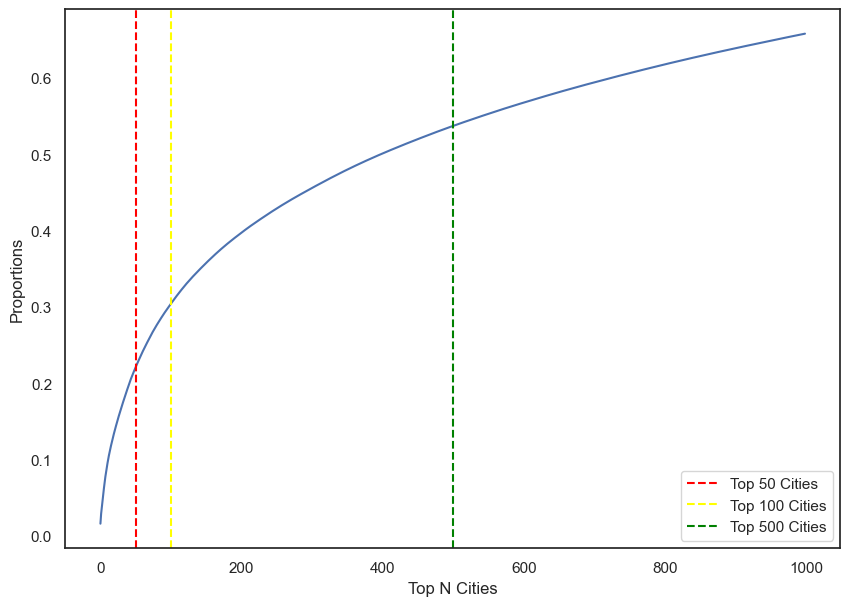

In [29]:
def city_longtail_visualized(df, year = None):
    if year is not None:
        df = df.query(f"year == {year}")
    else:
        total = len(df["ein"])
        counts = df["city"].value_counts()
        n_counts = np.array([counts.head(n).sum() for n in range(1, 1000)])
        proportions = n_counts/total

    plt.figure(figsize=(10, 7))
    plt.plot(proportions)
    plt.axvline(50, color = 'red', ls = '--', label = 'Top 50 Cities');
    plt.axvline(100, color = 'yellow', ls = '--', label = 'Top 100 Cities')
    plt.axvline(500, color = 'green', ls = '--', label = 'Top 500 Cities');
    plt.legend()
    plt.xlabel("Top N Cities")
    plt.ylabel("Proportions")
    plt.show()

    
city_longtail_visualized(df_cleaned)





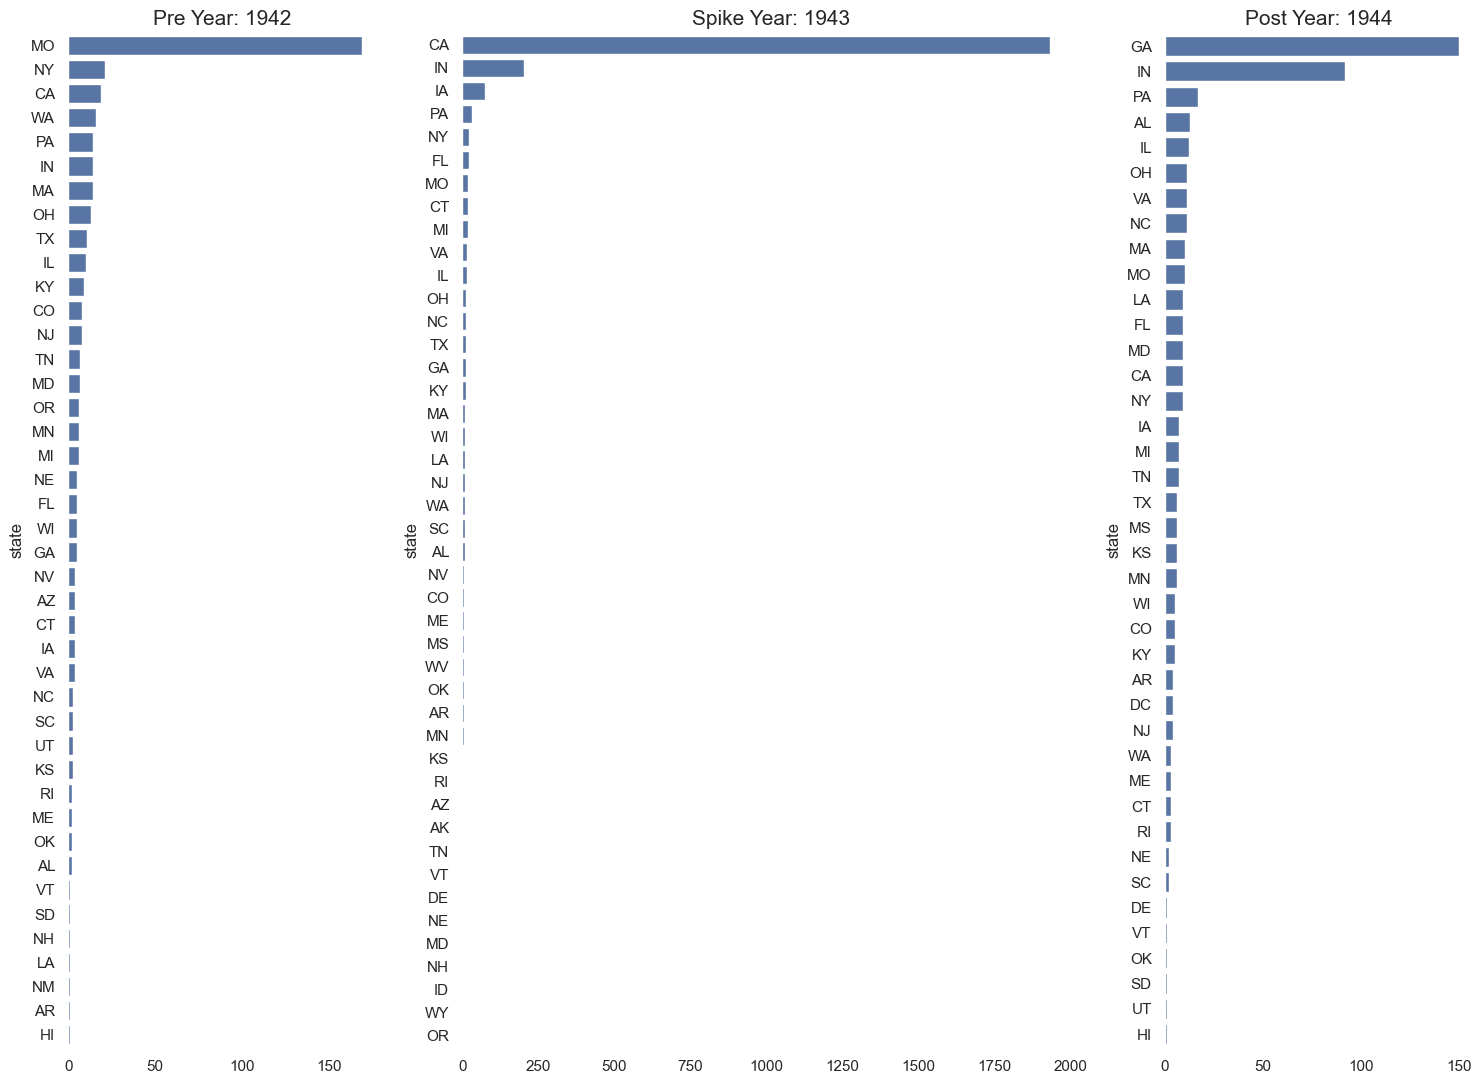

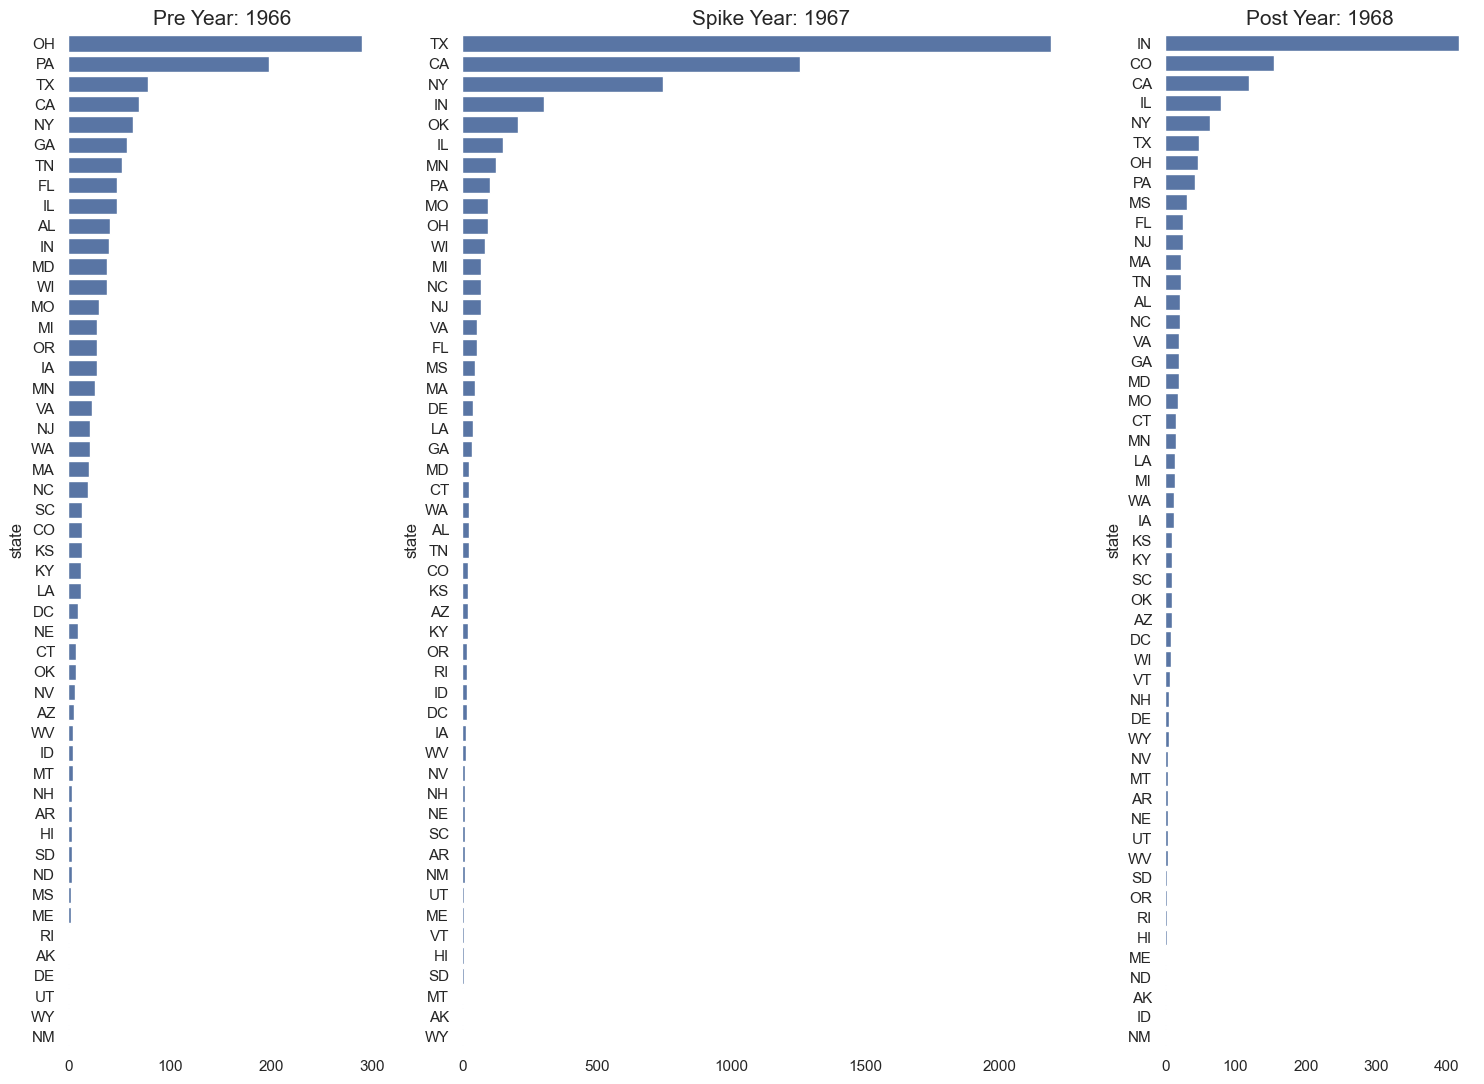

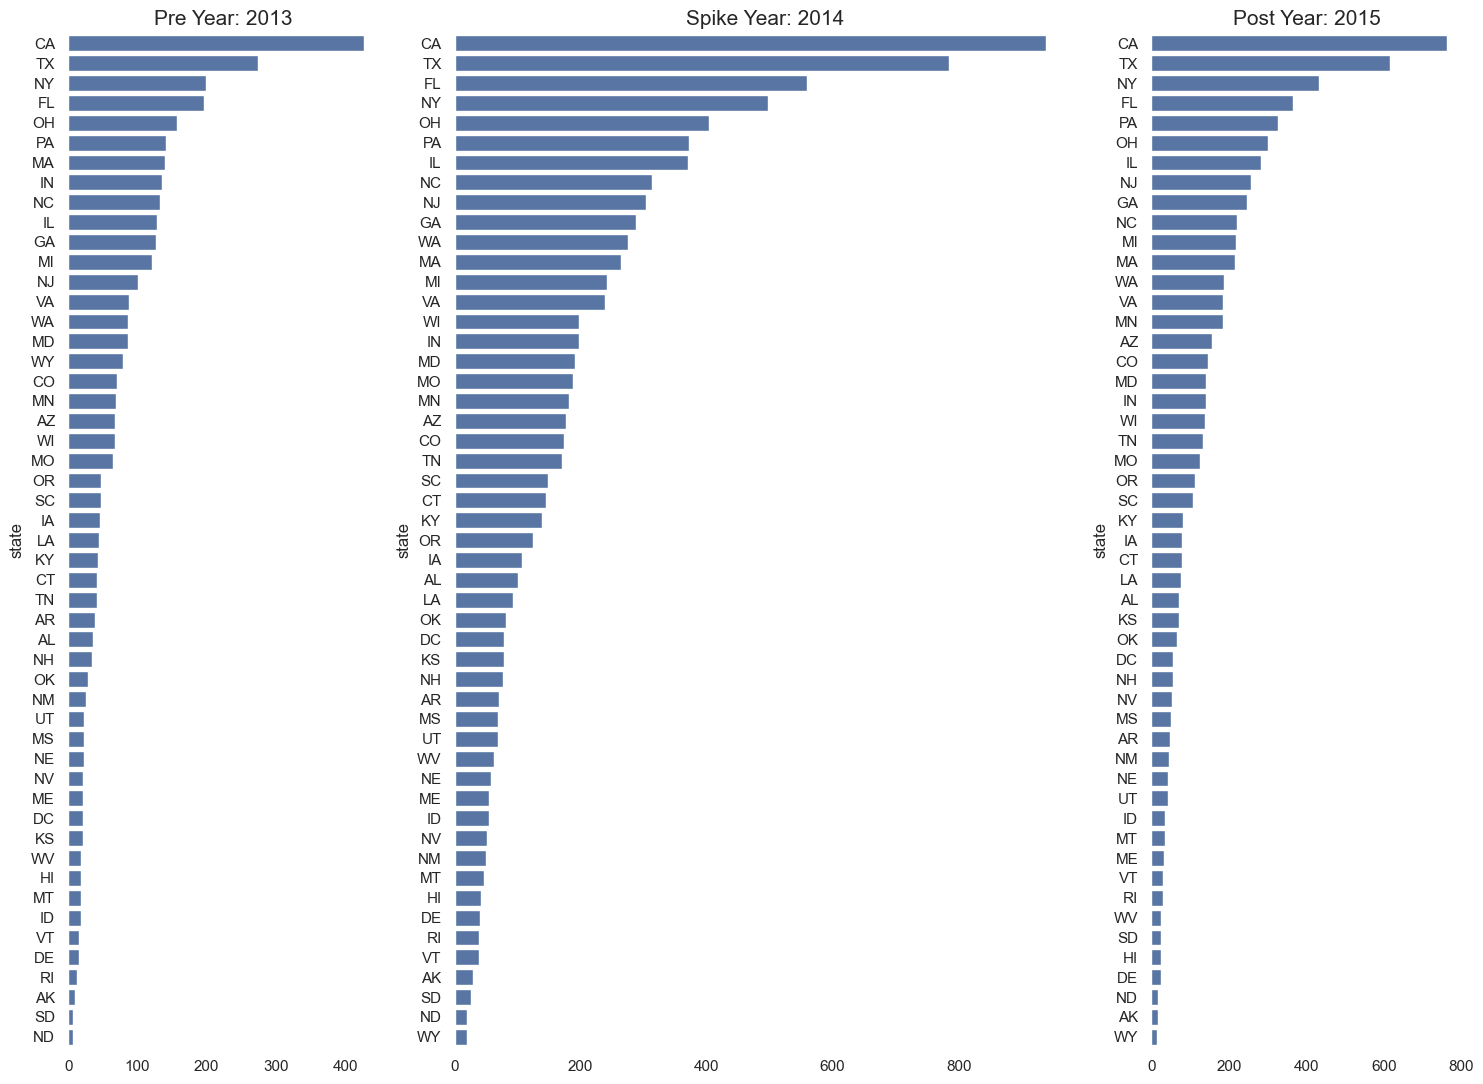

In [30]:
# FIGURE 4. INVESTIGATING SPIKES
# DANIEL, for Panel A, can you make the top and bottom rows smaller so that we can show how much of the spike is being driven by California in 1944, California and Texas in 1967, and digven by a handful of states by 2014?

def pre_post_spike(df, year, column, state=None):
    if state is not None:
        if type(state) == str:
            df = df[df["state"] == state]
        if type(state) == list:
            df = df[df["state"].isin(state)]

    spike = df[df['ruleyear'] == year][column].value_counts()
    pre = df[df['ruleyear'] == (year - 1)][column].value_counts()
    post = df[df['ruleyear'] == (year + 1)][column].value_counts()
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 11), gridspec_kw={'width_ratios': [1, 2, 1]})
    
    if state is not None:
        title1 = 'Pre Year: {} {}'.format(year - 1, state)
        title2 = 'Spike Year: {} {}'.format(year, state)
        title3 = 'Post Year: {} {}'.format(year + 1, state)
    else:
        title1 = 'Pre Year: {}'.format(year - 1)
        title2 = 'Spike Year: {}'.format(year)
        title3 = 'Post Year: {}'.format(year + 1)

    
    sns.barplot(x=pre.values, y=pre.index, ax=ax[0])
    ax[0].set_title(title1, fontsize=15)
    
    sns.barplot(x=spike.values, y=spike.index, ax=ax[1])
    ax[1].set_title(title2, fontsize=15)
    
    sns.barplot(x=post.values, y=post.index, ax=ax[2])
    ax[2].set_title(title3, fontsize=15)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

pre_post_spike(df_cleaned, 1943, "state")
pre_post_spike(df_cleaned, 1967, "state")
pre_post_spike(df_cleaned, 2014, "state")

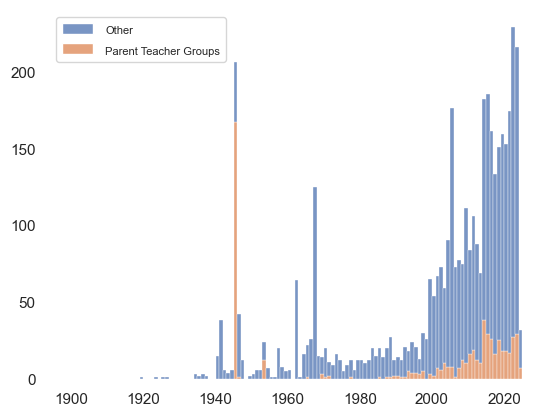

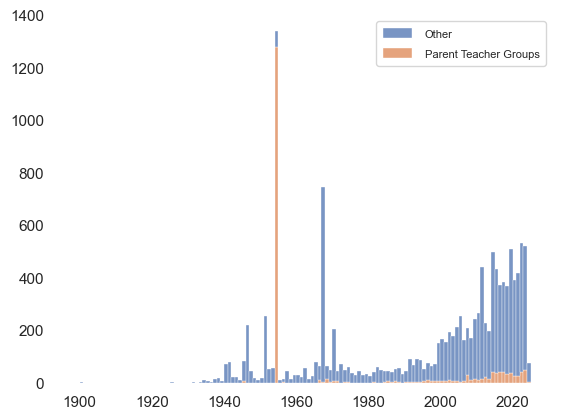

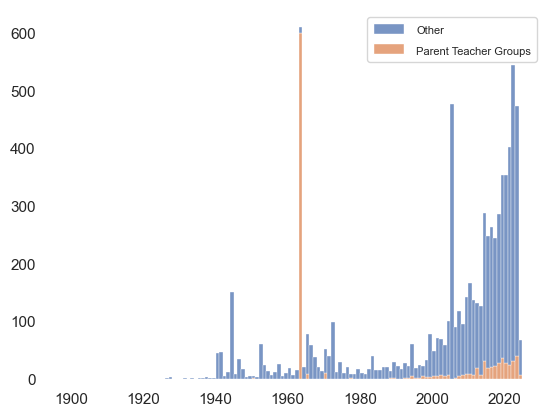

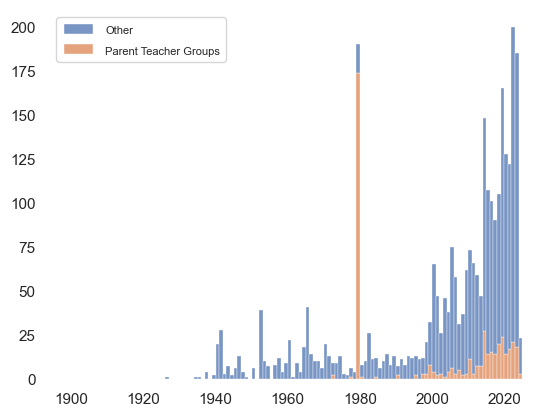

In [31]:

def visualize_ptg_spike(df, state_lst):
    for state in state_lst:
        state_df = df[df["state"] == state]
        state_df_no_B94 = state_df[state_df["ntee_irs"] != 'B94'].copy()
        state_df_B94 = state_df[state_df["ntee_irs"] == 'B94'].copy()
        
        state_df_no_B94.loc[:, ' '] = 'Other'
        state_df_B94.loc[:, ' '] = 'Parent Teacher Groups'
        
        combined_df = pd.concat([state_df_no_B94, state_df_B94])
        
        ax = sns.histplot(data=combined_df, x="ruleyear", hue=" ", multiple="stack", bins=range(1900, 2026))
        sns.despine(left=True, bottom=True)
    
        plt.ylabel("")
        plt.xlabel("")
        
        # Reduce the font size of the legend and remove the title
        legend = ax.get_legend()
        legend.set_title('')
        for text in legend.get_texts():
            text.set_fontsize(8)
        
        plt.show()


visualize_ptg_spike(df_cleaned, ["MN", "NY", "GA", "SC"])



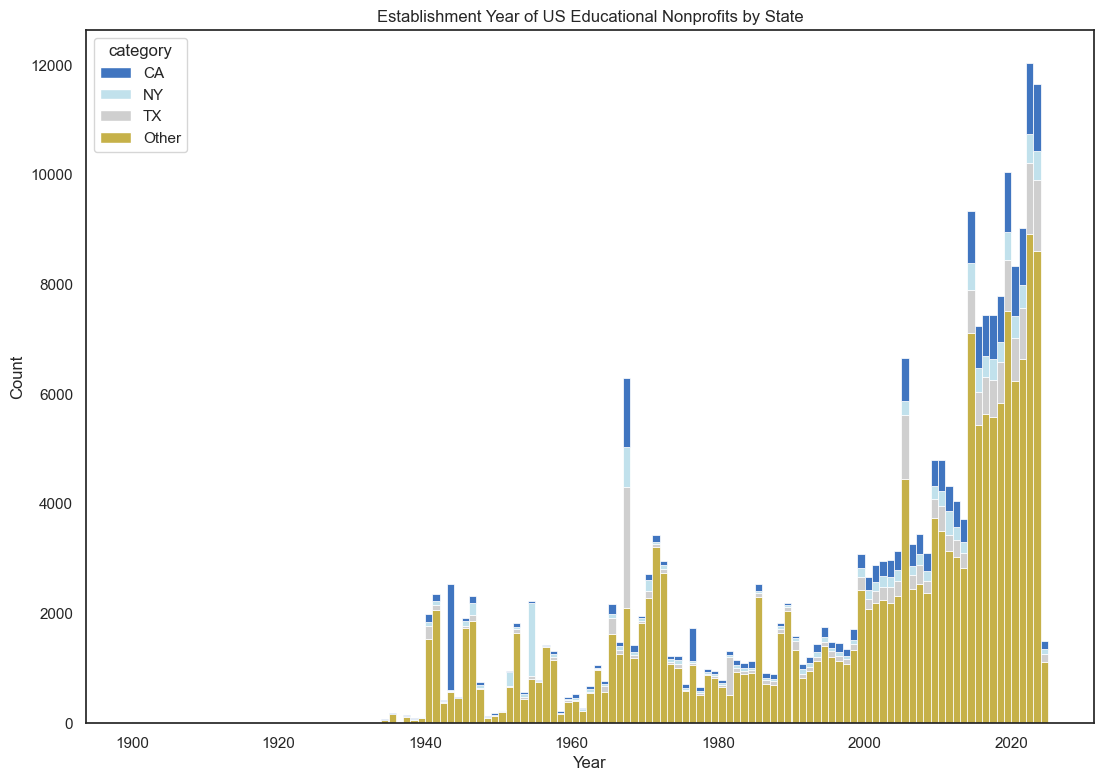

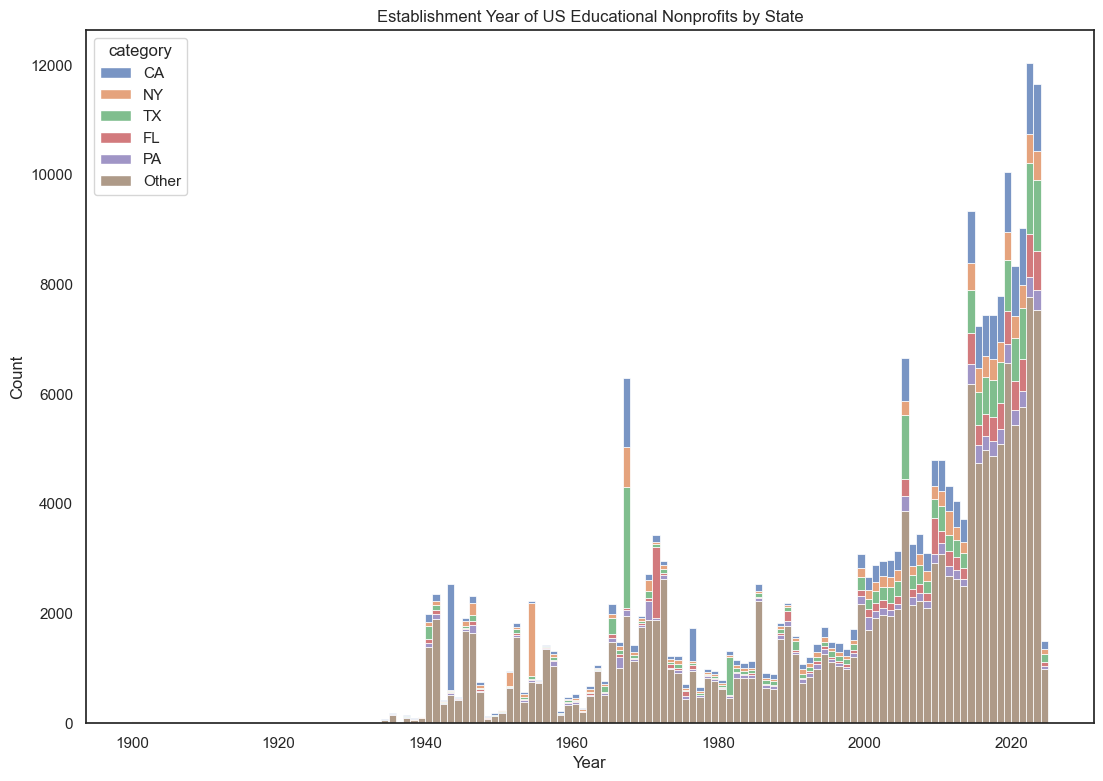

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
colors = {
    "CA": "#0047AB",  # cobalt
    "NY": "#ADD8E6",  # light blue
    "TX": "#C0C0C0",  # gold
    "Other": '#b3970c'  # silver (light grey for "Other")
     }



def stacked_hist(df, state_lst, year_col = "ruleyear",  colors = None):

    df_lst = []
    other = df[~df["state"].isin(state_lst)].copy()
    other['category'] = "Other"

    for state in state_lst:
        state_df = df[df["state"] == state].copy()
        state_df['category'] = state
        df_lst.append(state_df)
    
    df_lst.append(other)
    combined_df = pd.concat(df_lst)
    plt.figure(figsize=(13, 9))
    if colors is not None:
        sns.histplot(data=combined_df, x=year_col, hue="category", multiple="stack", bins=range(1900, 2026), palette=colors)
    else:
        sns.histplot(data=combined_df, x=year_col, hue="category", multiple="stack", bins=range(1900, 2026))
    plt.xlabel("Year")
    plt.title("Establishment Year of US Educational Nonprofits by State")
    plt.show()
    

# Example usage
stacked_hist(df_cleaned, ["CA", "NY", "TX"], colors = colors)
stacked_hist(df_cleaned, ["CA", "NY", "TX", "FL", "PA"], year_col="ruleyear")

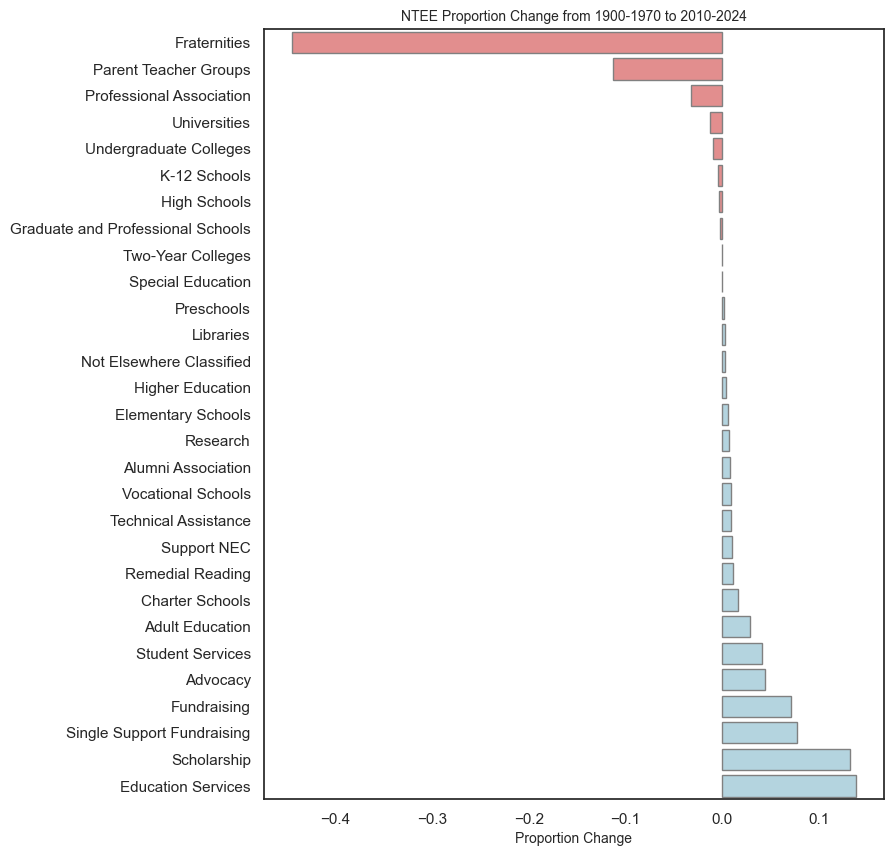

In [33]:
df_2010s = df_cleaned[df_cleaned["ruleyear"].isin([i for i in range(2010, 2024)])]
df_1970s = df_cleaned[df_cleaned['ruleyear'].isin([i for i in range(1900, 1970)])]

def period_proportions(df):
    period_counts = df["Main_Category"].value_counts().sort_index()
    total = period_counts.sum()
    proportions = period_counts / total
    percents = proportions 
    return percents

# Assuming df_2010s and df_1970s are your dataframes
proportion_change = (period_proportions(df_2010s) - period_proportions(df_1970s)).sort_values()

# Create a DataFrame with proportion change and colors
proportion_change_df = pd.DataFrame({
    'Main_Category': proportion_change.index,
    'Proportion_Change': proportion_change.values,
    'Color': ['lightblue' if x > 0 else 'lightcoral' for x in proportion_change]
})

plt.figure(figsize=(8, 10))
sns.barplot(
    data=proportion_change_df, 
    x='Proportion_Change', 
    y='Main_Category', 
    hue='Color', 
    dodge=False, 
    palette=['lightcoral', 'lightblue'], 
    legend=False,
    edgecolor = 'gray'
)
plt.title("NTEE Proportion Change from 1900-1970 to 2010-2024", fontsize = 10)
plt.xlabel("Proportion Change", fontsize = 10)
plt.ylabel("")
plt.show()


